# (Quick) Python introduction and horizon mask effect

<table>
  <tr>
    <td><img src="logos/CSTB_logo.jpg" width="200" />
    <td><img src="logos/Heliocity_logo.png" width="200" /> 
    <td><img src="logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>


This notebook introduces how to use python to explore data and calculate the effect of shading with the horizon mask from PVGIS.

It is broken down into two parts:

1. **Python introduction**: The student will follow the python introduction and is invited to execute the cells.
2. **Horizon mask effect**: The student is invited to apply the effect of shading on the horizon mask.

The attendees are very much welcome to modify and create/execute some new notebook cells to explore data and try out new methods.

**Make sure to manually execute the cells (ctrl + enter) yourself one by one**

The students are expected to do the <span style="color: red"> exercices </span> in red.

# 1. Python introduction

In this introduction, 4 topics will be tackled:

1. Filtering over a pandas Series or DataFrame
2. Use "If" and Loops commands
3. Make plots
4. Create python functions

In [1]:
# Import open source libraries to browse through the data folder and get our satellite data file
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Change the directory path to import functions from local modules
if not 'workbookDir' in globals():
    workbookDir = Path(os.getcwd()).parent
print('Work directory: ' + str(workbookDir))
os.chdir(workbookDir)

from src.config import DATA_PATH # Directory ROOT path

Work directory: C:\Users\MATHIEU\OneDrive - CSTBGroup\Bureau\Code\pvfault_detection_solar_academy


In [2]:
# Load satellite CAMs irradiance data
weather_data = pd.read_csv(DATA_PATH / "sat_data.csv", index_col=0)

weather_data.index = pd.to_datetime(weather_data.index).tz_convert("Europe/Paris")  # Convert the index to a datetime index and assign it to local time

print(weather_data.dropna().head(5))  # Show the first 5 lines, (all in W/m2)

                           ghi  dhi  dni
2022-01-01 01:00:00+01:00  0.0  0.0  0.0
2022-01-01 02:00:00+01:00  0.0  0.0  0.0
2022-01-01 03:00:00+01:00  0.0  0.0  0.0
2022-01-01 04:00:00+01:00  0.0  0.0  0.0
2022-01-01 05:00:00+01:00  0.0  0.0  0.0


In [3]:
# Load satellite position data calculated from NREL algorithm: I. Reda and A. Andreas, Solar position algorithm for solar radiation applications. Solar Energy, vol. 76, no. 5, pp. 577-589, 2004.
solar_position = pd.read_csv(DATA_PATH / "solarpos_data.csv", index_col=0)

solar_position.index = pd.to_datetime(solar_position.index).tz_convert("Europe/Paris")  # Convert the index to a datetime index and assign it to local time

print(solar_position.dropna().head(5))  # Show the first 5 lines, (all in ° degree)

                               zenith     azimuth
2022-01-01 01:00:00+01:00  153.182717  317.064974
2022-01-01 02:00:00+01:00  153.182717   17.989233
2022-01-01 03:00:00+01:00  148.059897   44.354858
2022-01-01 04:00:00+01:00  140.071691   63.762450
2022-01-01 05:00:00+01:00  130.744429   78.384802


# 1.1 Pandas Filtering

When it comes to make calculations faster or select a specific chunk of the DataFrame, filtering can be usefull

                                ghi       dhi       dni
2022-01-01 10:00:00+01:00  150.5869   61.0075  471.0327
2022-01-01 11:00:00+01:00  248.1986   63.4317  677.5654
2022-01-01 12:00:00+01:00  281.0088   84.9074  633.1003
2022-01-01 13:00:00+01:00  288.8650   67.8544  723.7922
2022-01-01 14:00:00+01:00  225.3259   70.7458  596.6607
...                             ...       ...       ...
2022-12-29 15:00:00+01:00  121.7313   64.2177  327.8066
2022-12-30 13:00:00+01:00  112.1809  109.6016    8.7161
2022-12-31 12:00:00+01:00  217.0507  150.5710  216.7422
2022-12-31 13:00:00+01:00  193.7134  161.4488  106.0832
2022-12-31 14:00:00+01:00  148.3794  138.0295   39.0728

[3190 rows x 3 columns]


<AxesSubplot:>

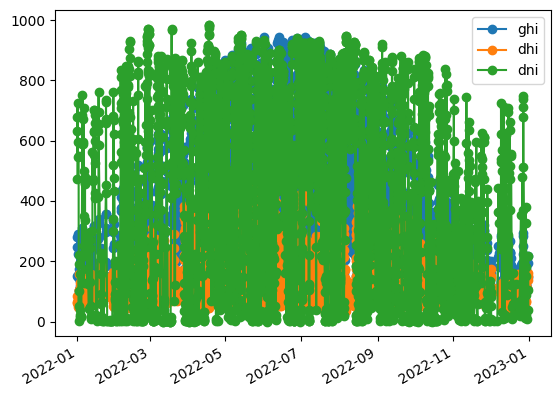

In [4]:
# Filter the dataframe when ghi is over a threshold
filter = weather_data["ghi"] > 100

print(weather_data.loc[filter])

# Plot it
weather_data.loc[filter].plot(marker="o")# Add markers

<AxesSubplot:>

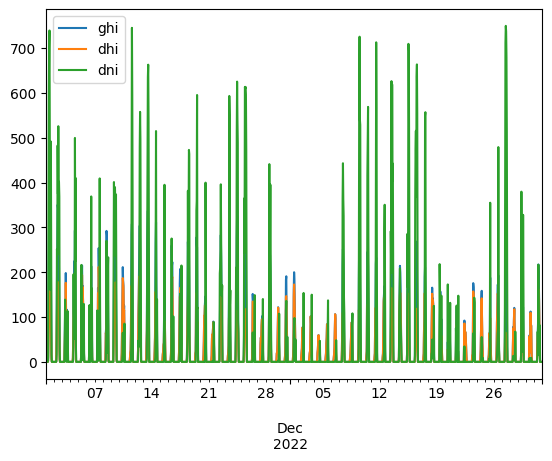

In [5]:
# Sometimes we don't see much about the data and it can be interesting to filter on some dates
filter_date = weather_data.index > pd.to_datetime("2022-11-01").tz_localize("CET") # Filter after the 1st of November
weather_data.loc[filter_date].plot()

<AxesSubplot:>

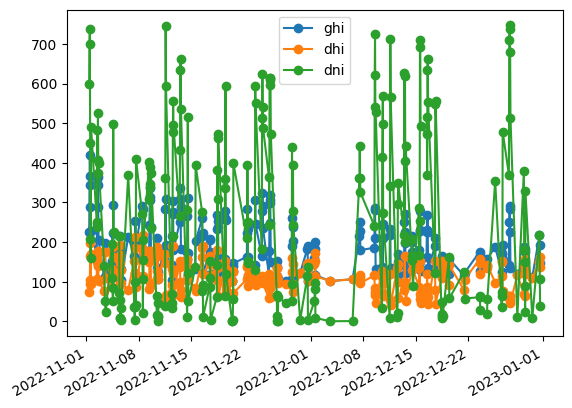

In [6]:
# The filters can add up
filter_all = filter | filter_date # or
filter_all2 = filter & filter_date # and
weather_data.loc[filter_all2].plot(marker="o")

In [7]:
# Note that only one column can also be selected according to a filter with the loc command
print(weather_data.loc[filter_all2, "ghi"].head(5))

2022-11-01 09:00:00+01:00    226.2636
2022-11-01 10:00:00+01:00    343.7006
2022-11-01 11:00:00+01:00    418.7252
2022-11-01 12:00:00+01:00    365.9074
2022-11-01 13:00:00+01:00    288.3209
Name: ghi, dtype: float64


## <span style="color: red"> Exercice </span>

Apply the following filters on weather_data with the condition "or":

- ghi > 800 W/m2
- between the 1st of July and the 1st of August

And plot dhi only

# 1.2. "If" and loops

"If" allows to verify and execute actions with an assertion.

On the other hand, loops enable to loop over all elements of a list or DataFrame for instance, to performance action on it.

In [8]:
# "If" allows to execute the next row (with a tabulation to the right) if the assertion is True
a=1
if a<0: # assertion: is "a" under 0 ?
    print("a is lower than 0") # Line non executed since the assertion above is wrong

In [9]:
if a>0:
    print("a is greater than 0") # Line  executed since the assertion above is right

a is greater than 0


In [10]:
# Sometimes operations can not be applied directly with pd.Series and loops allow to go through each element of a list or serie
my_list = ["element 1","element 2"]
for element in my_list:
    print(element)

element 1
element 2


In [11]:
# It can be applied to pd.Series
ts = pd.Series([1,2,3])
for element in ts:
    print(element**2)

1
4
9


In [12]:
# For dataFrame, one can use the "iterrows" method
df = pd.DataFrame()
df["column1"] = [1,2,3]
df["column2"] = [1, 3, 5]
print(df)

   column1  column2
0        1        1
1        2        3
2        3        5


In [13]:
ts_stock = pd.Series(dtype=float) # Prepare the recipient to store the values

for index, row in df.iterrows(): # Loop over all rows of the dataframe one by one
    print(row["column1"] + row["column2"])
    ts_stock.loc[index] = row["column1"] + row["column2"]

2
5
8


In [14]:
print(ts_stock)

0    2
1    5
2    8
dtype: int64


## <span style="color: red"> Exercice </span>

Create a new pd.Serie timeserie from df which have the same indexes and has a 1 in its row value if the sum over the df row is greater than 4, otherwise, assign 0

# 1.3. Plots

Text(0.5, 1.0, 'My title')

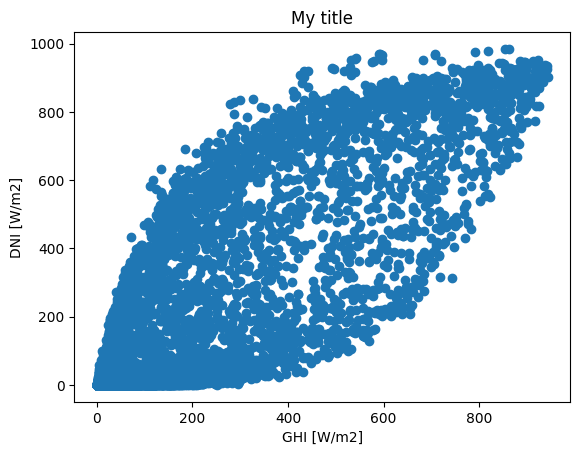

In [15]:
# Here is an example about how to make a plot with the matplotlib.pyplot library
plt.plot(weather_data["ghi"], weather_data["dni"], linewidth=0, marker="o")

plt.xlabel('GHI [W/m2]')
plt.ylabel('DNI [W/m2]')
plt.title("My title")

# 1.4. Functions

Functions enable package small algorithms which are easy to apply and to re-use

In [16]:
# Define the function "" with the "def" command and a small increment tab to the right
def cos_aoi_function(beta, azimuth, sun_elevation, sun_azimuth):
    cos_aoi = np.cos(beta* np.pi/180)*np.sin(sun_elevation*np.pi/180) +np.sin(beta*np.pi/180)*np.cos(sun_elevation*np.pi/180)*np.cos((azimuth-sun_azimuth)*np.pi/180)
    return cos_aoi

# Installation orientation
beta = 20 # tilt [°]
azimuth = 180 # azimuth [°]
sun_elevation = 72 # sun elevation [°]
s_azimuth = 173.9 # sun azimuth [°]

cos_aoi = cos_aoi_function(beta, azimuth, sun_elevation, s_azimuth)
print(cos_aoi)

0.9987924041267017


## <span style="color: red"> Exercice </span>

Apply the function cos_aoi_function() on the pd.DataFrame "solar_position"


## 2.1 Mask Horizon effect

<span style="color: red"> Add the horizon file from PVGIS in the "data" folder by browsing on the left pan and indicate the filename below </span>

In [17]:
# Indicate the full csv-file path
file = DATA_PATH / "horizon_45.181_5.714.csv"

In [18]:
# Import the file into a pandas DataFrame  (skip some rows and add some arguments to make the dataframe clean))
data = pd.read_csv(file, sep='\t', skiprows=3, skipfooter=8, engine="python").dropna(axis=1)

data = data[["A", "H_hor"]]
data.columns = ["azimuth", "elevation"]
data["azimuth"] = data["azimuth"] + 180 # (to have the convention with 0° is North, 90° East etc...)
data.head()

,azimuth,elevation
0,0.0,7.6
1,7.5,6.1
2,15.0,7.6
3,22.5,8.8
4,30.0,8.4


## <span style="color: red"> Exercice </span>

a. Plot the elevation as function of the azimuth with matplotlib

b. Apply the shading effect on the direct POA component, ie if the sun elevation is under the horizon line, POAb = 0 W/m2

Advice: You might want to create a loop over the dataframe which contains the POA data and calculate the shading elevation for each of its time step in a new column